# iCAT Montage
---
#### Overview
The purpose of this notebook is to montage (or stitch together) individual sections (or layers) of image data. This is done by first gathering the set of neighboring tiles  in each section and then generating point matches from these neighboring images (or tile pairs). `render-ws` includes functionality for gathering the set of neighboring tiles as well as for generating point matches, accessed by making calls to `renderapi.client.tilePairClient` and `renderapi.client.pointMatchClient`, respectively.

In [1]:
import re
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt

#### Settings

In [2]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

# Set matplotlib colormap
plt.set_cmap('magma')
plt.close();

# `altair` settings
alt.data_transformers.disable_max_rows();

## Set up `render-ws` environment
---

In [3]:
import renderapi
from icatapi.render_pandas import create_stack_DataFrame, create_stacks_DataFrame

In [4]:
# `render` project parameters
# ---------------------------
owner = 'rlane'
project = 'pancreas'
project_dir = Path(f'/long_term_storage/{owner}/{project}')

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'rlane',
 'project': 'pancreas',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

In [5]:
# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]
stacks_2_montage = ['EM_himag']
match_collections = {k: v for k, v in zip(stacks_2_montage,
                                          [f"{project}_{stack}_points" for stack in stacks_2_montage])}

# Output
# ------
out = f"""\
project directory... {project_dir} | Exists: {project_dir.exists()}
all stacks.......... {stacks}
EM stacks........... {stacks_EM}
FM stacks........... {stacks_FM}
stacks to montage... {stacks_2_montage}
match collections... {match_collections}
...
"""
print(out)

# Create project DataFrame
# ------------------------
df_project = create_stacks_DataFrame(stacks=stacks_2_montage,
                                     render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.head(3))

project directory... /long_term_storage/rlane/pancreas | Exists: True
all stacks.......... ['Hoechst', 'EM_lomag', 'EM_himag', 'AF594']
EM stacks........... ['EM_lomag', 'EM_himag']
FM stacks........... ['Hoechst', 'AF594']
stacks to montage... ['EM_himag']
match collections... {'EM_himag': 'pancreas_EM_himag_points'}
...



tileId    z   width  height   minint   maxint  \
stack                                                               
EM_himag 0  aaa_lil_EM-...  4.0  4096.0  4096.0  31039.0  32893.0   
         1  aab_lil_EM-...  4.0  4096.0  4096.0  31039.0  32893.0   
         2  aac_lil_EM-...  4.0  4096.0  4096.0  31039.0  32893.0   

                  imageUrl          tforms     stack sectionId  imageRow  \
stack                                                                      
EM_himag 0  https://son...  [M=[[1.0000...  EM_himag      S004         6   
         1  https://son...  [M=[[1.0000...  EM_himag      S004         6   
         2  https://son...  [M=[[1.0000...  EM_himag      S004         6   

            imageCol    stageX    stageY  
stack                                     
EM_himag 0         6  1078.477  6335.559  
         1         5  1060.996  6335.559  
         2         4  1043.523  6335.571

## Generate point matches
---

#### Collect tile pairs

Tile pairs are any two tiles that overlap with each other (possibly including diagonally). Collection of tile pairs is generated from a `render-python` client script. This client selects a set of tiles `p` based on its position in a stack and then searches for nearby `q` tiles using geometric parameters.

script | code
------ | ----
client script | [`renderapi.client.tilePairClient`](https://github.com/fcollman/render-python/blob/721ac8845e3067af6c81f3c67f2c0fa24fb1723c/renderapi/client/client_calls.py#L129)
java script | [`TilePairClient.java`](https://github.com/saalfeldlab/render/blob/master/render-ws-java-client/src/main/java/org/janelia/render/client/TilePairClient.java)


In [6]:
from icatapi.montage import get_tile_pairs_4_montage

In [7]:
# Initialize tile pairs DataFrame
df_pairs = pd.DataFrame()

# Loop through montage stacks
for stack in tqdm(stacks_2_montage):

    # Get tile pairs for each stack
    df = get_tile_pairs_4_montage(stack=stack,
                                  render=render)
    df_pairs = pd.concat([df_pairs, df])

# Preview
out = f"{len(df_pairs)} tile pairs"
print(out + '\n' + '.'*len(out))

df_pairs.reset_index(drop=True, inplace=True)
df_pairs.groupby('stack')\
        .apply(lambda x: x.sample(7))

  0%|          | 0/1 [00:00<?, ?it/s]

160 tile pairs
..............


stack    z p.groupId            p.id p.relativePosition  \
stack                                                                      
EM_himag 35   EM_himag  4.0      S004  aat_lil_EM-...          BOTTOM      
         45   EM_himag  5.0      S005  aac_lil_EM-...           RIGHT      
         135  EM_himag  7.0      S007  aai_lil_EM-...          BOTTOM      
         3    EM_himag  4.0      S004  aab_lil_EM-...           RIGHT      
         156  EM_himag  7.0      S007  aau_lil_EM-...           RIGHT      
         22   EM_himag  4.0      S004  aam_lil_EM-...          BOTTOM      
         131  EM_himag  7.0      S007  aag_lil_EM-...          BOTTOM      

             q.groupId            q.id q.relativePosition  
stack                                                      
EM_himag 35       S004  aau_lil_EM-...             TOP     
         45       S005  aad_lil_EM-...            LEFT     
         135      S007  aal_lil_EM-...             TOP     
         3        S004  aac_lil_EM-...            LEFT     
         156      S007  aav_lil_EM-...            LEFT     
         22       S004  aar_lil_EM-...             TOP     
         131      S007  aan_lil_EM-...             TOP

### Run `pointMatchClient`
##### Set `SIFT` & `RANSAC` parameters

In [8]:
from renderapi.client import (MatchDerivationParameters,
                              FeatureExtractionParameters,
                              SiftPointMatchOptions)

In [9]:
# `RANSAC` parameters
match_params = MatchDerivationParameters(matchIterations=None,
                                         matchMaxEpsilon=25,        # maximal alignment error
                                         matchMaxNumInliers=None,
                                         matchMaxTrust=None,
                                         matchMinInlierRatio=0.05,  # minimal inlier ratio
                                         matchMinNumInliers=7,      # minimal number of inliers
                                         matchModelType='RIGID',    # expected transformation
                                         matchRod=0.92)             # closest/next closest ratio
# `SIFT` parameters
feature_params = FeatureExtractionParameters(SIFTfdSize=8,          # feature descriptor size
                                             SIFTmaxScale=0.25,     # (width/height *) maximum image size
                                             SIFTminScale=0.05,     # (width/height *) minimum image size
                                             SIFTsteps=7)           # steps per scale octave
# Combined `SIFT` & `RANSAC` parameters
sift_options = SiftPointMatchOptions(**{**match_params.__dict__,
                                        **feature_params.__dict__})
# Add clipping options
sift_options.clipWidth = 4000   # N pixels included in rendered clips of LEFT/RIGHT oriented montage tiles
sift_options.clipHeight = 4000  # N pixels included in rendered clips of TOP/BOTTOM oriented montage tiles

# Preview
list(sift_options.to_java_args())

['--SIFTfdSize',
 '8',
 '--SIFTmaxScale',
 '0.25',
 '--SIFTminScale',
 '0.05',
 '--SIFTsteps',
 '7',
 '--matchMaxEpsilon',
 '25',
 '--matchMinInlierRatio',
 '0.05',
 '--matchMinNumInliers',
 '7',
 '--matchModelType',
 'RIGID',
 '--matchRod',
 '0.92',
 '--clipWidth',
 '4000',
 '--clipHeight',
 '4000']

#### \*\****COMPUTATIONALLY EXPENSIVE*** \**

##### Run `pointMatchClient` on `N_cores`

In [10]:
from icatapi.montage import generate_point_matches

In [11]:
# Set number of cores and batch size
N_cores = 25
batch_size = 12

# Generate point matches
generate_point_matches(df_pairs,
                       match_collections=match_collections,
                       sift_options=sift_options,
                       normalizeForMatching=True,
                       N_cores=N_cores,
                       batch_size=batch_size,
                       render=render)

## Analyze point matches
---

### Collect point matches
Sort of forced to iterate through tile pairs because no data is returned for tile pairs with no matches

In [12]:
# Initialize DataFrame for point matches
df_matches = pd.DataFrame(columns=['stack', 'pGroupId', 'pId', 'pc', 'pr',
                                            'qGroupId', 'qId', 'qc', 'qr', 'N'])

# Loop through stacks to align
i = 0
for stack in tqdm(stacks_2_montage):

    # Get sectionIds per stack
    pGroupIds = renderapi.pointmatch.get_match_groupIds(matchCollection=match_collections[stack],
                                                        render=render)
    # Loop through sectionIds
    for pGroupId in tqdm(pGroupIds, leave=False):

        # Get json data for point matches by sectionId
        json_matches = renderapi.pointmatch.get_matches_within_group(matchCollection=match_collections[stack],
                                                                     groupId=pGroupId,
                                                                     render=render)

        # Convert json data to DataFrame
        df = pd.json_normalize(json_matches)
        df_matches = df_matches.append(df, sort=False).reset_index(drop=True)

        # Add columns for stack and number of point matches
        df_matches.loc[i:i+len(df), 'stack'] = stack
        df_matches.loc[i:i+len(df), 'N'] = df_matches['matches.p'].apply(lambda x: np.array(x).shape[1])
        i += len(df)

# Merge with DataFrame of tile pairs to also get empty matches
df_matches = pd.merge(
    df_matches,
    df_pairs.rename(columns={'p.groupId': 'pGroupId',
                             'q.groupId': 'qGroupId',
                             'p.id': 'pId',
                             'q.id': 'qId'})\
            .drop(['p.relativePosition',
                   'q.relativePosition'], axis=1, errors='ignore'),
    how='outer',
    on=['stack', 'pGroupId', 'pId', 'qGroupId', 'qId'])

# Add row/col indices
df_matches[['pc', 'pr']] = np.stack(df_matches['pId'].apply(lambda x:\
                                    [int(i) for i in re.findall(r'\d+', x)[-2:]]))
df_matches[['qc', 'qr']] = np.stack(df_matches['qId'].apply(lambda x:\
                                    [int(i) for i in re.findall(r'\d+', x)[-2:]]))

# Preview
out = f"""\
{len(df_matches.dropna())} / \
{len(df_matches)} \
({len(df_matches.dropna())/len(df_matches):.1%}) \
tile pair matches"""
print(out + '\n' + '.'*len(out))

df_matches.groupby('stack')\
          .apply(lambda x: x.sample(3))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

160 / 160 (100.0%) tile pair matches
....................................


stack pGroupId             pId  pc  pr qGroupId  \
stack                                                             
EM_himag 51  EM_himag     S005  aag_lil_EM-...   3   5     S005   
         6   EM_himag     S004  aad_lil_EM-...   3   6     S004   
         44  EM_himag     S005  aac_lil_EM-...   4   6     S005   

                        qId  qc  qr      N  matchCount       matches.p  \
stack                                                                    
EM_himag 51  aah_lil_EM-...   4   5  159.0       159.0  [[3728.5027...   
         6   aae_lil_EM-...   2   6  205.0       205.0  [[380.64122...   
         44  aad_lil_EM-...   3   6  297.0       297.0  [[375.54537...   

                  matches.q       matches.w    z  
stack                                             
EM_himag 51  [[205.56531...  [1.0, 1.0, ...  5.0  
         6   [[3911.1843...  [1.0, 1.0, ...  4.0  
         44  [[3893.2036...  [1.0, 1.0, ...  5.0

### Heatmaps of point matches

#### East-West point matches

In [13]:
# Filter point matches DataFrame to East-West (LEFT, RIGHT) tile pairs
source = df_matches.loc[df_matches['pr'] == df_matches['qr']]\
                   .copy()
source['pqc'] = source.loc[:, ['pc', 'qc']].min(axis=1)
source.loc[source['N'] == 0, 'N'] = np.nan

# Make heatmap
base = alt.Chart(source).encode(
    x='pqc:O',
    y='pr:O'
)
heatmap = base.mark_rect().encode(
    color=alt.Color('N:Q'),
).properties(
    width=300,
    height=300
)
text = base.mark_text(baseline='middle').encode(
    text='N:Q',
)
# Facet heatmaps across sections and montage stacks
alt.layer(heatmap, text, data=source).facet(
    column=r'pGroupId:N',
    row='stack:N'
)

alt.FacetChart(...)

#### North-South point matches

In [14]:
# Filter point matches DataFrame to North-South (TOP, BOTTOM) tile pairs
source = df_matches.loc[df_matches['pc'] == df_matches['qc']]\
                   .copy()
source['pqr'] = source.loc[:, ['pr', 'qr']].min(axis=1)
source.loc[source['N'] == 0, 'N'] = np.nan

# Make heatmap
base = alt.Chart(source).encode(
    x='pc:O',
    y='pqr:O'
)
heatmap = base.mark_rect().encode(
    color=alt.Color('N:Q'),
).properties(
    width=300,
    height=300
)
text = base.mark_text(baseline='middle').encode(
    text='N:Q',
)
# Facet heatmaps across sections and montage stacks
alt.layer(heatmap, text, data=source).facet(
    column=r'pGroupId:N',
    row='stack:N'
)

alt.FacetChart(...)

### Distribution of number of matches

In [15]:
# Data source
source = df_matches.copy()

# Distribution plot
dist = alt.Chart(source).mark_bar().encode(
    x=alt.X('N',
            bin=alt.Bin(maxbins=64)),
    y='count():Q',
    color='stack:O'
).properties(
    height=220,
    width=350
)

# Facet distribution plots across sections and montage stacks
alt.layer(dist, data=source).facet(
    column='pGroupId:N',
    row='stack:N'
)

alt.FacetChart(...)

## Montage
---

### Edit `montage.json`

In [16]:
import json
from pprint import pprint

In [19]:
# Load montage json template
template_montage_json = Path('../templates/montage.json')
with template_montage_json.open('r') as json_data:
    montage_settings = json.load(json_data)

# Edit montage settings for each montage stack
for (stack, z, sectionId), df in df_project.loc[(df_project['stack'].isin(stacks_2_montage))] \
                                           .groupby(['stack', 'z', 'sectionId']):

    # Edit BigFeta solver schema
    montage_settings['first_section'] = z
    montage_settings['last_section'] = z
    montage_settings['solve_type'] = 'montage'
    montage_settings['transformation'] = 'rigid'
    montage_settings['log_level'] = "INFO"

    # Edit input stack data
    montage_settings['input_stack']['owner'] = owner
    montage_settings['input_stack']['project'] = project
    montage_settings['input_stack']['name'] = stack

    # Edit point match stack data
    montage_settings['pointmatch']['owner'] = owner
    montage_settings['pointmatch']['name'] = match_collections[stack]

    # Edit output stack data
    montage_settings['output_stack']['owner'] = owner
    montage_settings['output_stack']['project'] = project
    montage_settings['output_stack']['name'] = f'{stack}_montaged'

    # Edit regularization parameters
    montage_settings['regularization']['default_lambda'] = 0.005      # default: 0.005
    montage_settings['regularization']['translation_factor'] = 0.005  # default: 0.005
    montage_settings['regularization']['thinplate_factor'] = 1e-5     # default: 1e-5

    # Export montage settings to
    montage_json = project_dir / stack / sectionId / '_montage.json'
    with montage_json.open('w') as json_data:
        json.dump(montage_settings, json_data, indent=2)

# Sample montage json
print(montage_json)
print('...')
pprint(montage_settings)

/long_term_storage/rlane/pancreas/EM_himag/S007/_montage.json
...
{'close_stack': 'True',
 'first_section': 7.0,
 'hdf5_options': {'chunks_per_file': -1, 'output_dir': ''},
 'input_stack': {'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
                 'collection_type': 'stack',
                 'db_interface': 'mongo',
                 'host': 'sonic.tnw.tudelft.nl',
                 'mongo_host': 'sonic.tnw.tudelft.nl',
                 'mongo_port': 27017,
                 'name': 'EM_himag',
                 'owner': 'rlane',
                 'port': 8080,
                 'project': 'pancreas'},
 'last_section': 7.0,
 'log_level': 'INFO',
 'matrix_assembly': {'cross_pt_weight': 1.0,
                     'depth': 2,
                     'inverse_dz': 'True',
                     'montage_pt_weight': 1.0,
                     'npts_max': 500,
                     'npts_min': 5},
 'output_mode': 'stack',
 'output_stack': {'client_scripts': '/home/c

### Edit `mongod` configuration
Needs to be refined, but this works for now. Involves opening mongodb to remote IPs which might be dangerous?

##### Normal `/etc/mongod.conf` configuration
```
# network interfaces
net:
  port: 27017
#  bindIp: 0.0.0.0
  bindIp: 127.0.0.1 # Listen to local interface only, comment to listen on all interfaces.
#  bindIp: 127.0.0.1 169.254.100.2 131.180.83.183 172.17.0.1
```

##### Make changes and restart mongod
```
# network interfaces
net:
  port: 27017
  bindIp: 0.0.0.0
#  bindIp: 127.0.0.1 # Listen to local interface only, comment to listen on all interfaces.
#  bindIp: 127.0.0.1 169.254.100.2 131.180.83.183 172.17.0.1
```

### Run `BigFeta` montage

In [20]:
import os
import subprocess

In [21]:
# Path to `BigFeta`
cwd = Path.cwd().as_posix()
BigFeta_dir = Path('/home/catmaid/BigFeta/')

# Loop through each section of montage stacks
for (stack, z, sectionId), df in tqdm(df_project.loc[(df_project['stack'].isin(stacks_2_montage))]\
                                                .groupby(['stack', 'z', 'sectionId'])):

    # Select montage json
    montage_json = project_dir / stack / sectionId / '_montage.json'

    # Call `BigFeta.BigFeta` process -- have to switch to BigFeta directory
    os.chdir(BigFeta_dir.as_posix())
    subprocess.run(['python', '-m', 'bigfeta.bigfeta', '--input_json', montage_json.as_posix()])
    os.chdir(cwd)

  0%|          | 0/4 [00:00<?, ?it/s]

## Inspect montaged stacks
---

In [25]:
from icatapi.plotting import plot_tile_map, plot_neighborhoods, plot_stacks

### Montaged stacks DataFrame

In [22]:
# Collect montaged stacks
stacks_montaged = [stack for stack in \
                   renderapi.render.get_stacks_by_owner_project(render=render)\
                   if '_montaged' in stack]
df_montaged = create_stacks_DataFrame(stacks_montaged,
                                      render=render)
# Preview
df_montaged.groupby('stack')\
           .apply(lambda x: x.sample(6))

tileId    z   width  height   minint   maxint  \
stack                                                                       
EM_himag_mon... 27  aac_lil_EM-...  5.0  4096.0  4096.0  30825.0  32870.0   
                49  aay_lil_EM-...  5.0  4096.0  4096.0  30825.0  32870.0   
                31  aag_lil_EM-...  5.0  4096.0  4096.0  30825.0  32870.0   
                92  aar_lil_EM-...  7.0  4096.0  4096.0  31112.0  33082.0   
                60  aak_lil_EM-...  6.0  4096.0  4096.0  30931.0  32897.0   
                1   aab_lil_EM-...  4.0  4096.0  4096.0  31039.0  32893.0   

                          imageUrl          tforms           stack sectionId  \
stack                                                                          
EM_himag_mon... 27  https://son...  [M=[[0.2213...  EM_himag_mo...      S005   
                49  https://son...  [M=[[0.2220...  EM_himag_mo...      S005   
                31  https://son...  [M=[[0.2212...  EM_himag_mo...      S005   
                92  https://son...  [M=[[0.2138...  EM_himag_mo...      S007   
                60  https://son...  [M=[[0.2653...  EM_himag_mo...      S006   
                1   https://son...  [M=[[0.2309...  EM_himag_mo...      S004   

                    imageRow  imageCol    stageX    stageY  
stack                                                       
EM_himag_mon... 27         6         4  1640.490  6343.345  
                49         2         2  1605.439  6413.457  
                31         5         3  1623.695  6360.823  
                92         3         4  2839.856  6382.614  
                60         4         6  2285.151  6380.840  
                1          6         5  1060.996  6335.559

### Tile map

  0%|          | 0/4 [00:00<?, ?it/s]

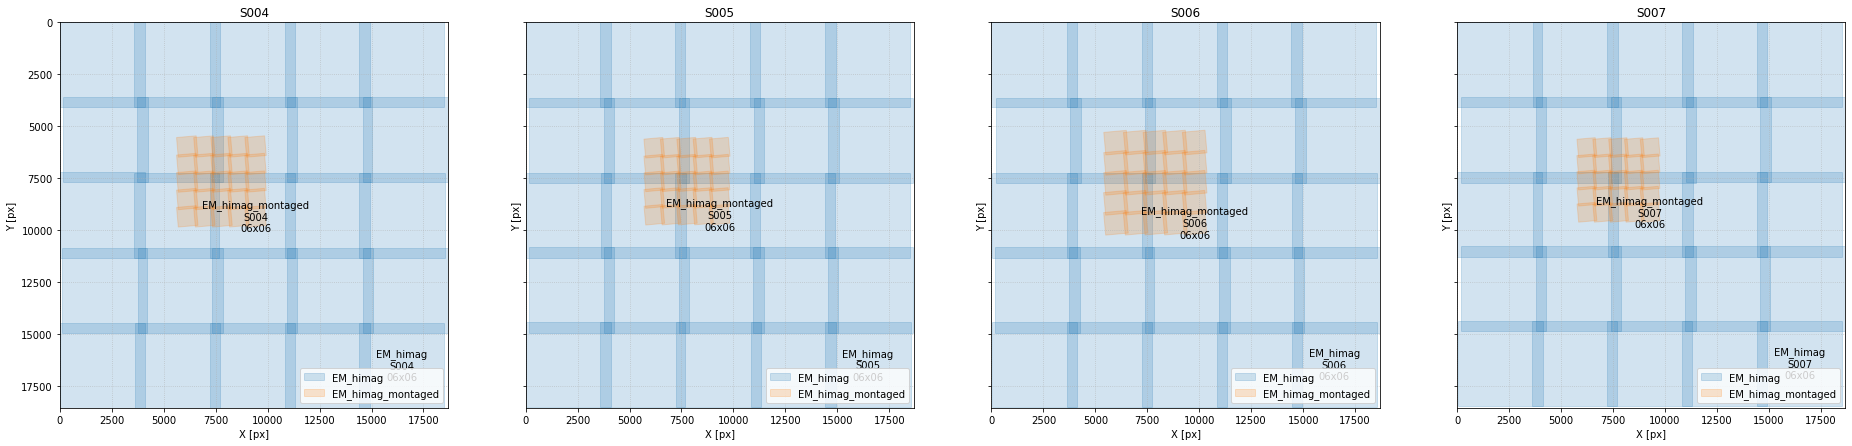

In [26]:
stacks_2_plot = stacks_2_montage + stacks_montaged

plot_tile_map(stacks=stacks_2_plot,
              render=render)

### Render neighborhood images

  0%|          | 0/8 [00:00<?, ?it/s]

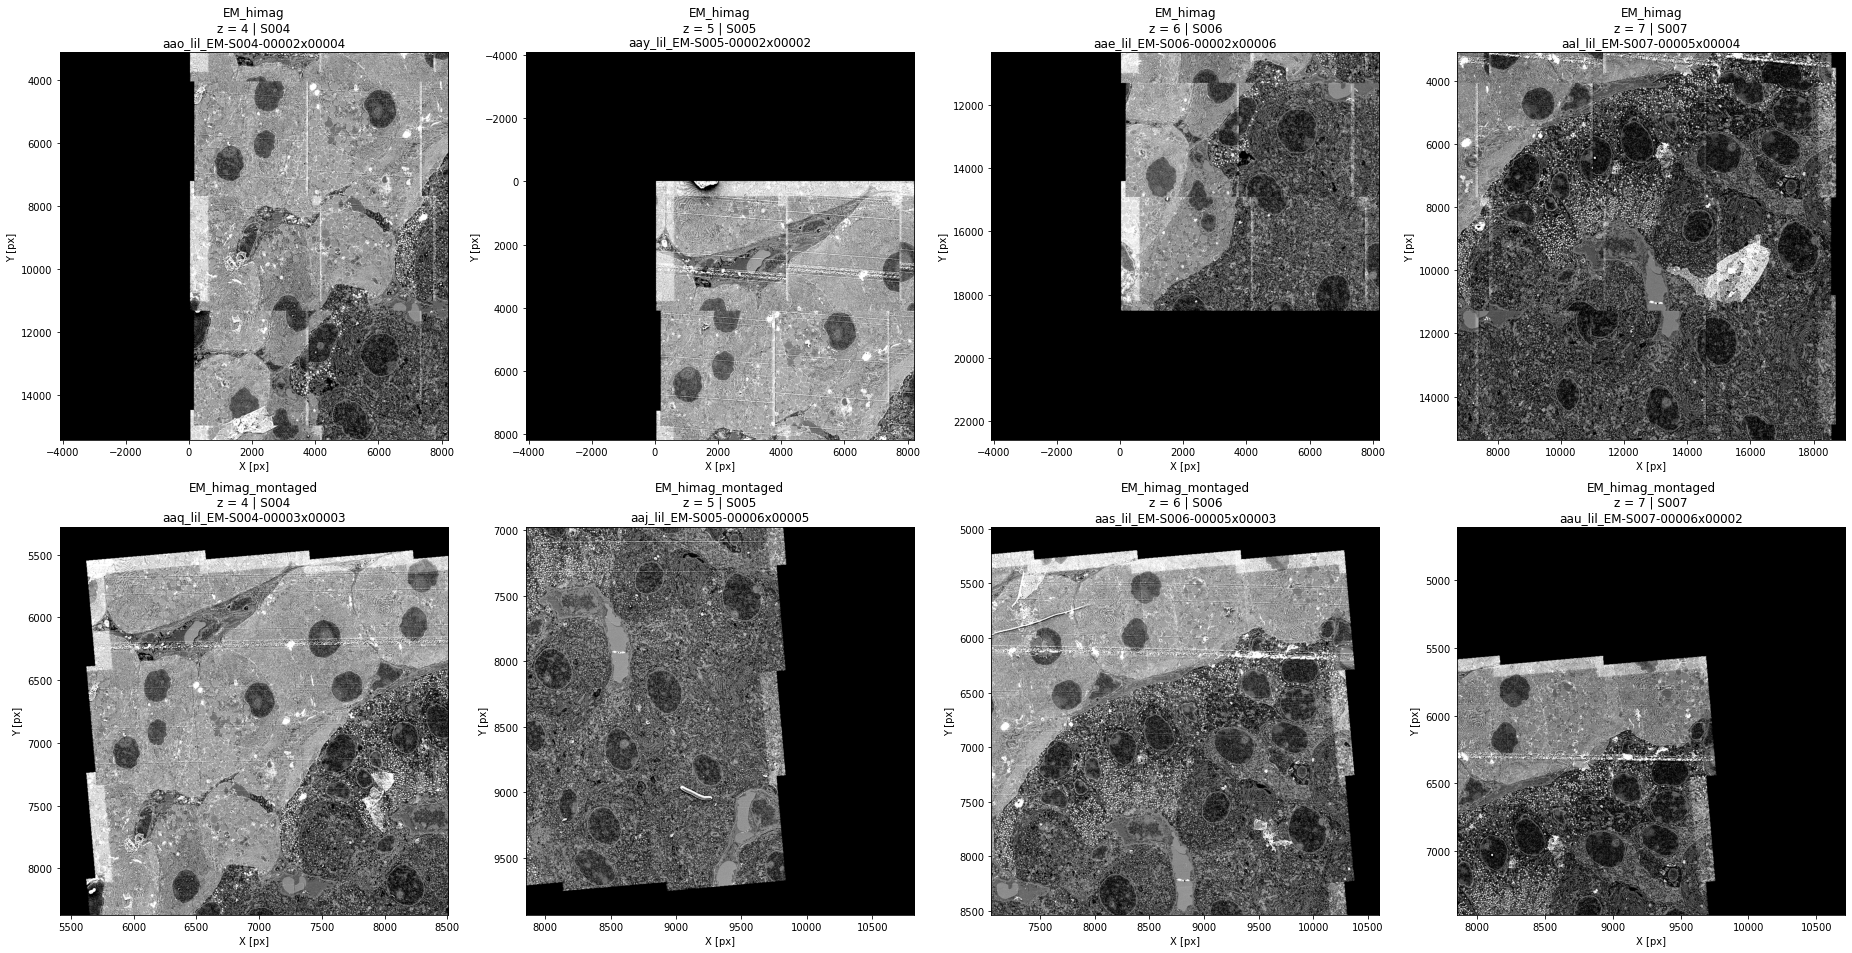

In [27]:
stacks_2_plot = stacks_2_montage + stacks_montaged

plot_neighborhoods(stacks_2_plot, neighborhood=1, render=render)

### Render stack images

  0%|          | 0/4 [00:00<?, ?it/s]

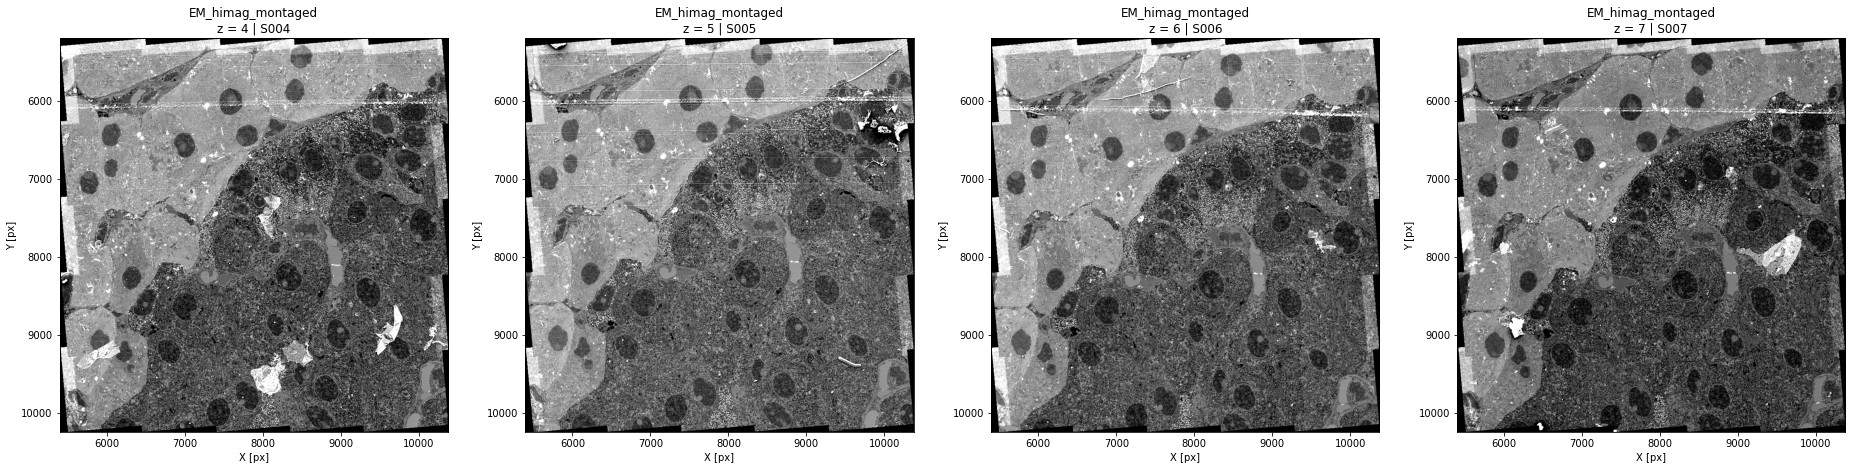

In [28]:
stacks_2_plot = stacks_montaged

plot_stacks(stacks_2_plot,
            maxTileSpecsToRender=100,
            render=render)

## Remove island tiles
---
#### Look at distribution of transformations

In [33]:
df_stack = create_stack_DataFrame(stack='EM_himag_montaged',
                                  render=render)

T_cols = ['M00', 'M10', 'M01', 'M11', 'B0', 'B1']
df_stack[T_cols] = pd.DataFrame(df_stack['tforms']\
           .apply(lambda x: x[0].dataString)\
           .str.split(' ', expand=True).values, columns=T_cols)\
           .astype(float)
tforms = df_stack.loc[:, T_cols]
tforms

M00       M10       M01       M11           B0           B1
0   0.230900 -0.019498  0.019498  0.230900  8903.239182  8910.387185
1   0.230934 -0.020051  0.020051  0.230934  8086.469400  8909.851943
2   0.230883 -0.020658  0.020658  0.230883  7266.469399  8913.230185
3   0.230936 -0.019800  0.019800  0.230936  6441.456720  8911.359377
4   0.230941 -0.020340  0.020340  0.230941  5617.546976  8911.539367
..       ...       ...       ...       ...          ...          ...
95  0.214289 -0.018448  0.018448  0.214289  8807.275455  5637.449772
96  0.214352 -0.018958  0.018958  0.214352  8049.033807  5637.414134
97  0.214409 -0.018975  0.018975  0.214409  7288.175629  5635.595460
98  0.214445 -0.018292  0.018292  0.214445  6524.891134  5632.180161
99  0.214518 -0.018906  0.018906  0.214518  5762.298273  5631.873447

[100 rows x 6 columns]

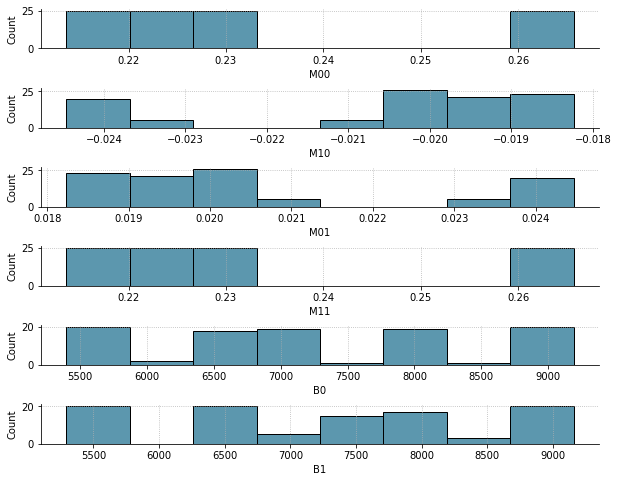

In [34]:
fig, axes = plt.subplots(nrows=len(tforms.columns),
                         figsize=(10, 8))
for i, k in enumerate(df_stack[T_cols]):
    sns.histplot(tforms[k], ax=axes[i], color='#267593')
#     sns.boxplot(x=k, data=tforms, orient='h', whis=None, fliersize=3, ax=axes[i])
#     sns.stripplot(x=k, data=tforms, orient='h', color='.3', size=3, ax=axes[i])
    axes[i].grid(ls=':')
    sns.despine(ax=axes[i])
plt.subplots_adjust(hspace=1)

#### Filter island tiles

In [35]:
# Initialize island tiles
island_tileIds = []

for z, layer in df_stack.groupby('z'):

    # Get transform data
    columns = ['M00', 'M10', 'M01', 'M11', 'B0', 'B1']
    tforms = pd.DataFrame(layer['tforms']\
               .apply(lambda x: x[0].dataString)\
               .str.split(' ', expand=True).values, columns=columns)\
               .astype(float)
    
    # Choose lower and upper limits
    ll = tforms['M00'].mean() - 3*tforms['M00'].std()
    ul = tforms['M00'].mean() + 3*tforms['M00'].std()
    island_tileIds_ = layer.loc[(layer['tforms'].apply(lambda x: x[0].M00) < ll) | \
                                (layer['tforms'].apply(lambda x: x[0].M00) > ul)]['tileId'].values
    island_tileIds += island_tileIds_.tolist()

# Island tiles
island_tileIds[:]

[]

#### Create filtered stack

In [ ]:
df_stack = create_stack_DataFrame(stack='EM_himag_montaged',
                                  render=render)
create_stack_from_DataFrame(df_stack,
                            name='EM_himag_filtered',
                            render=render)

In [ ]:
renderapi.stack.set_stack_state(stack='EM_himag_filtered',
                                state='LOADING',
                                render=render)

for tileId in island_tileIds:
    renderapi.stack.delete_tile(stack='EM_himag_filtered',
                                tileId=tileId,
                                render=render)

renderapi.stack.set_stack_state(stack='EM_himag_filtered',
                                state='COMPLETE',
                                render=render)

In [ ]:
stacks_2_plot = stacks_2_montage + ['EM_himag_filtered']

plot_tile_map(stacks=stacks_2_plot,
              render=render)

## Scale montage
---

In [43]:
from matplotlib.transforms import Affine2D as AffineMPL
from renderapi.transform import AffineModel as AffineRender
from icatapi.render_pandas import create_stack_from_DataFrame

In [44]:
# Create stack DataFrame
df_stack = create_stack_DataFrame(stack='EM_himag_montaged',
                                  render=render)

# Loop through sections
for z, layer in tqdm(df_stack.groupby('z'),
                     total=len(df_stack['z'].unique())):

    # Get transform data
    columns = ['M00', 'M10', 'M01', 'M11', 'B0', 'B1']
    tforms = pd.DataFrame(layer['tforms']\
               .apply(lambda x: x[0].dataString)\
               .str.split(' ', expand=True).values, columns=columns)\
               .astype(float)

    # Extract scale from affine transform
    M = AffineMPL(np.array([[tforms['M00'].mean(), tforms['M01'].mean(), 0],
                            [tforms['M10'].mean(), tforms['M11'].mean(), 0],
                            [                   0,                    0, 1]]))
    R, S = np.linalg.qr(M.get_matrix())
    mask = np.diag(S) < 0.
    S[mask, :] *= -1.
    # Set scale
    sx = 1/S[0,0]
    sy = 1/S[1,1]

    # Create transform
    T = AffineMPL().scale(sx, sy)
    A = AffineRender()
    A.M = T.get_matrix()

    # Add scale transform to DataFrame
    for i, tile in layer.iterrows():
        df_stack.at[i, 'tforms'] += [A]
#         df_stack.at[i, 'tforms'].insert(0, A)

  0%|          | 0/4 [00:00<?, ?it/s]

In [45]:
# Create scaled DataFrame
create_stack_from_DataFrame(df=df_stack,
                            name='EM_himag_scaled',
                            render=render)

Creating tile specifications for EM_himag_scaled...
Importing tile specifications to EM_himag_scaled...
Stack EM_himag_scaled created successfully.


  0%|          | 0/4 [00:00<?, ?it/s]

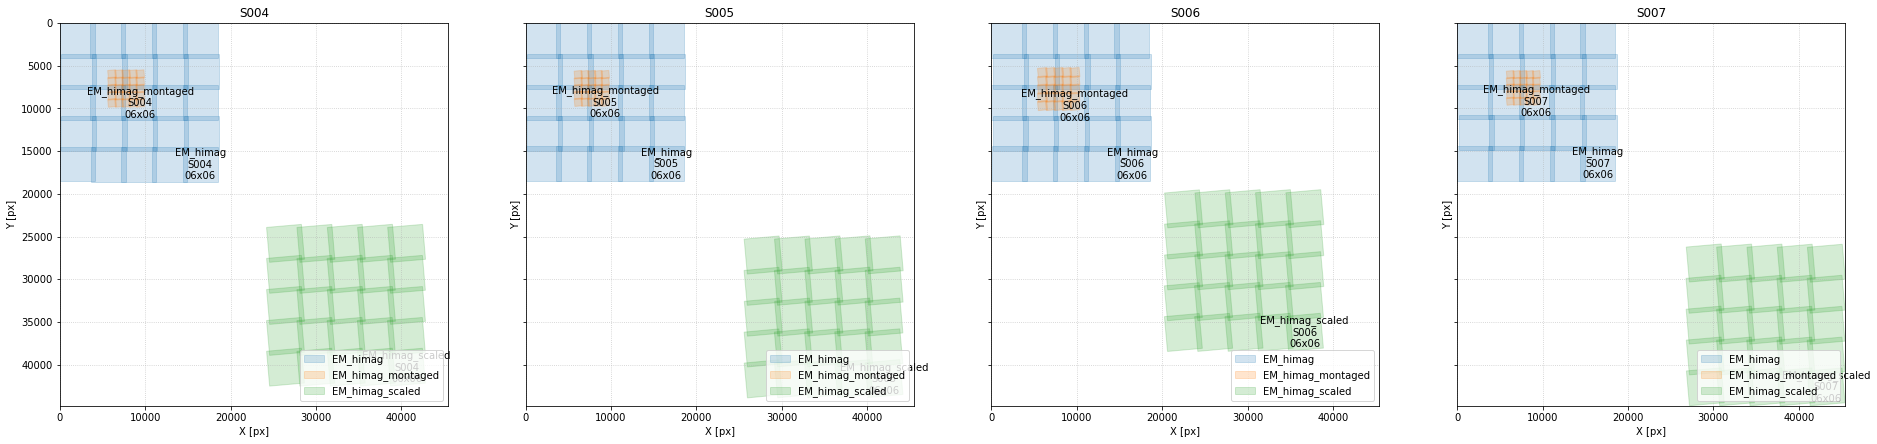

In [47]:
stacks_2_plot = stacks_2_montage + ['EM_himag_montaged', 'EM_himag_scaled']

plot_tile_map(stacks=stacks_2_plot,
              render=render)

#### Translate back

In [48]:
# Create stack DataFrame
df_stack = create_stack_DataFrame(stack='EM_himag_scaled',
                                  render=render)

# Loop through sections
for z, layer in tqdm(df_stack.groupby('z'),
                     total=len(df_stack['z'].unique())):

    # Get transform data
    columns = ['M00', 'M10', 'M01', 'M11', 'B0', 'B1']
    tforms = pd.DataFrame(layer['tforms']\
               .apply(lambda x: x[0].dataString)\
               .str.split(' ', expand=True).values, columns=columns)\
               .astype(float)

    # Extract scale from affine transform
    M = AffineMPL(np.array([[tforms['M00'].mean(), tforms['M01'].mean(), 0],
                            [tforms['M10'].mean(), tforms['M11'].mean(), 0],
                            [                   0,                    0, 1]]))
    R, S = np.linalg.qr(M.get_matrix())
    mask = np.diag(S) < 0.
    S[mask, :] *= -1.
    # Set translation
    tx = tforms['B0'].abs().min() * 1/S[0,0]
    ty = tforms['B1'].abs().min() * 1/S[1,1]

    # Create transform
    T = AffineMPL().translate(-tx, -ty)
    A = AffineRender()
    A.M = T.get_matrix()

    # Add scale transform to DataFrame
    for i, tile in layer.iterrows():
        df_stack.at[i, 'tforms'] += [A]

  0%|          | 0/4 [00:00<?, ?it/s]

In [49]:
# Create scaled DataFrame
create_stack_from_DataFrame(df=df_stack,
                            name='EM_himag_stitched',
                            render=render)

Creating tile specifications for EM_himag_stitched...
Importing tile specifications to EM_himag_stitched...
Stack EM_himag_stitched created successfully.


  0%|          | 0/4 [00:00<?, ?it/s]

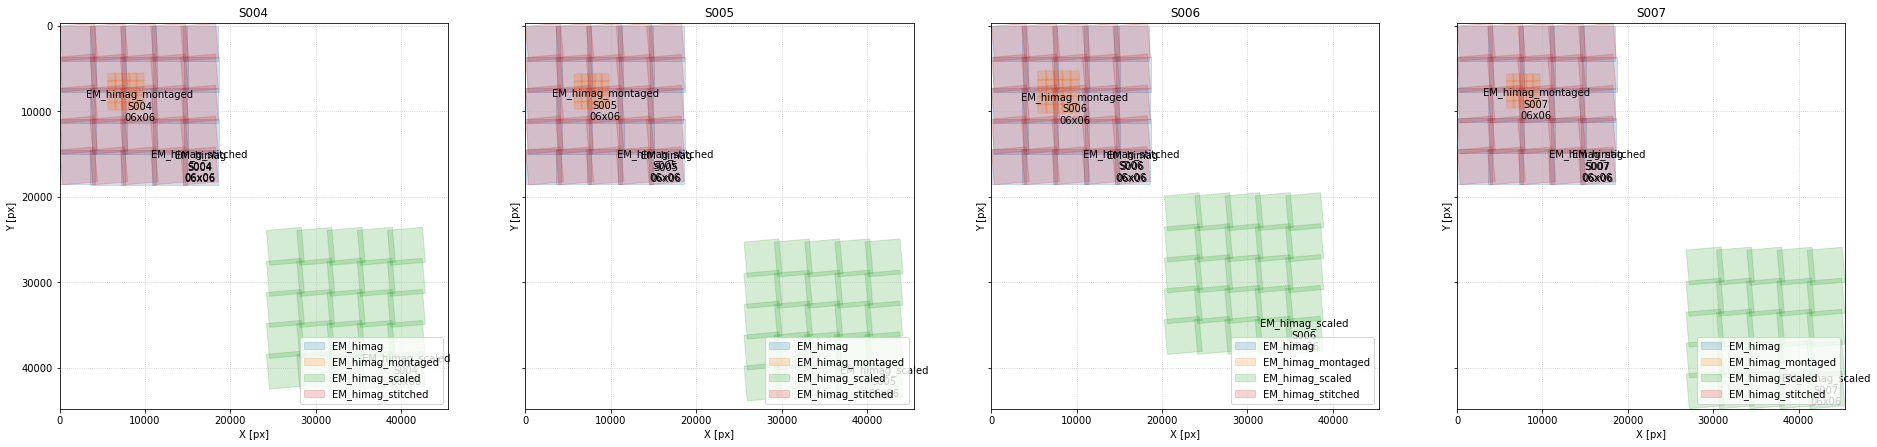

In [51]:
stacks_2_plot = stacks_2_montage + ['EM_himag_montaged', 'EM_himag_scaled', 'EM_himag_stitched']

plot_tile_map(stacks=stacks_2_plot,
              render=render)